#

### Install required packages (do this only once):

In [1]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install statsmodels
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install sklearn

Requirement already up-to-date: pip in /Users/awicenec/.pyenv/versions/py3.8/lib/python3.8/site-packages (20.2.3)


### Get a few libraries

In [2]:
import pandas as pd               # This is the workhorse for everything Data Science in Python
import matplotlib.pyplot as plt   # very powerful python plotting library
import seaborn as sns             # high level plots
import statsmodels.api as sm
import scipy
import numpy as np
from sklearn.linear_model import LinearRegression

/Users/awicenec/.pyenv/versions/py3.8/lib/python3.8/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: cannot import name 'SemLock' from '_multiprocessing' (/Users/awicenec/.pyenv/versions/py3.8/lib/python3.8/lib-dynload/_multiprocessing.cpython-38-darwin.so).  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


ImportError: This platform lacks a functioning sem_open implementation, therefore, the required synchronization primitives needed will not function, see issue 3770.

#### Read the data

In [3]:
df = pd.read_csv('data/mario1000.csv')  # That's just the CSV data you've received

In [4]:
# How does that look like?
df

,Country,Region,Gender,Ageyears,Handed,Height,Foot_Length,Arm_Span,Languages_spoken,Travel_to_School,...,Reaction_time,Score_in_memory_game,Favourite_physical_activity,Importance_reducing_pollution,Importance_recycling_rubbish,Importance_conserving_water,Importance_saving_enery,Importance_owning_computer,Importance_Internet_access,Unnamed: 20
0,OZ,Victoria,F,12,R,154,25,146,2,Car,...,0.560,51.0,Table Tennis,1,598.0,687,722.0,1.0,125.0,NaN
1,USA,NJ,F,15,R,170,27,163,1,Walk,...,0.361,0.0,Running/Jogging,503,743.0,342,NaN,364.0,348.0,NaN
2,UK,North West,F,14,R,159,22,162,1,Bus,...,0.290,43.0,Dancing,714,843.0,851,816.0,216.0,302.0,NaN
3,NZ,Auckland,F,10,R,131,20,134,1,Car,...,0.619,0.0,Netball,750,NaN,1000,NaN,NaN,NaN,NaN
4,USA,AZ,F,17,R,153,22,160,1,Walk,...,0.300,30.0,Tennis,500,450.0,650,800.0,100.0,100.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,OZ,New South Wales,F,15,R,185,26,181,2,Bus,...,0.370,22.0,Netball,527,533.0,805,409.0,462.0,610.0,NaN
996,USA,HI,F,17,R,154,25,149,1,Car,...,0.700,43.0,Tennis,400,300.0,800,800.0,1000.0,1000.0,NaN
997,NZ,Taranaki,M,10,L,149,21,150,1,Car,...,0.000,0.0,Rugby Union,0,NaN,1000,NaN,NaN,NaN,NaN
998,CA,Nova Scotia,M,18,R,175,30,173,1,Car,...,0.330,47.0,Hockey (Ice),1000,503.0,294,497.0,497.0,561.0,NaN


In [5]:
df.keys()

Index(['Country', 'Region', 'Gender', 'Ageyears', 'Handed', 'Height',
       'Foot_Length', 'Arm_Span', 'Languages_spoken', 'Travel_to_School',
       'Travel_time_to_School', 'Reaction_time', 'Score_in_memory_game',
       'Favourite_physical_activity', 'Importance_reducing_pollution',
       'Importance_recycling_rubbish', 'Importance_conserving_water',
       'Importance_saving_enery', 'Importance_owning_computer',
       'Importance_Internet_access', 'Unnamed: 20'],
      dtype='object')

#### Create a histogram plot of reaction times of females and males

In [6]:
# Some global settings used a lot below
GROUPBY = ['Gender']   # dataset will be grouped by these columns
VALUE_COLUMN = 'Reaction_time'   # the column used as a value (should be numerical)
X_TITLE = VALUE_COLUMN           # the title for the x-axis
Y_TITLE = GROUPBY                # the title for the y-axis
SCALED = True                    # normalized histograms or not

In [7]:
df_G = df.groupby(GROUPBY)       # perform the grouping

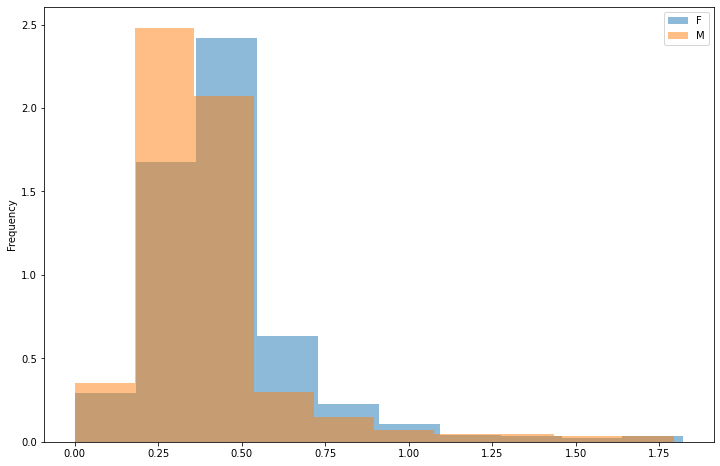

In [8]:
# This is pretty powerful: it plots the histograms for all groups using a single command. The rest of the keywords are just to tidy things up a bit.

_ = df_G[VALUE_COLUMN].plot.hist(figsize=(12,8), legend=True, alpha=0.5, density=SCALED)

#### Fixing the labels using the figure directly:

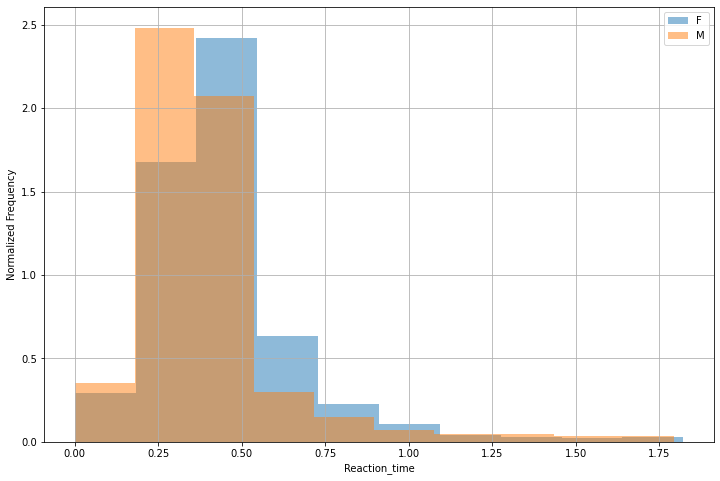

In [9]:
fig = plt.figure(figsize=[12,8])  # start a figure with a certain size
ax = fig.gca()                    # get the figure axes
df_G[VALUE_COLUMN].hist(ax=ax, legend=True, alpha=0.5, density=SCALED) # draw the histograms on it.
_ = ax.set_xlabel(X_TITLE)
_ = ax.set_ylabel('Frequency')
if SCALED: ax.set_ylabel('Normalized Frequency')
plt.show()

### Now we are trying to deal with the 'outliers':

We need to do this for the groups separately:

In [10]:
# This is assuming that we have just two groups:
df_f = df[VALUE_COLUMN].where(df['Gender'] == 'F')
df_m = df[VALUE_COLUMN].where(df['Gender'] == 'M')

In [11]:
def remove_outliers(s, low=None, high=None, index=False):
    # just a small helper function to remove outliers above or below certain quantiles
    if not low:
        low = 0.25   # standard for outlier definition
    if not high:
        high = 1 - low
    iqr = scipy.stats.iqr(s, nan_policy='omit')
    if not index:
        return s[s.between(s.quantile(low)-1.5*iqr, s.quantile(high)+1.5*iqr)]
    else:
        return s.between(s.quantile(low)-1.5*iqr, s.quantile(high)+1.5*iqr)

In [12]:
def outlier_cutoff(s):  
    iqr = scipy.stats.iqr(s, nan_policy='omit')
    return {'iqr':iqr, 'lower bound': s.quantile(0.25)-1.5*iqr, 'upper bound': s.quantile(0.75)+1.5*iqr}

In [13]:
df_fc = remove_outliers(df_f, low=0.25)
df_mc = remove_outliers(df_m, low=0.25)
df_f = df[VALUE_COLUMN].where(df['Gender'] == 'F')

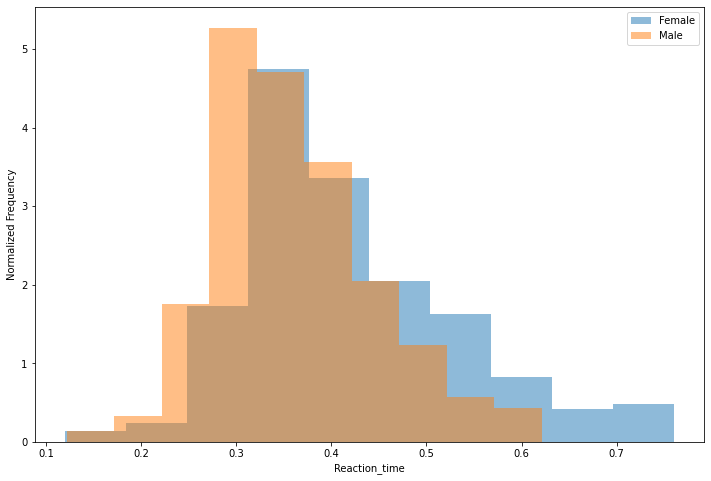

In [14]:
fig = plt.figure(figsize=[12,8])  # start a new figure with a certain size
ax = fig.gca()                    # get the figure axes
_ = df_fc.plot.hist(ax=ax, figsize=(12,8), legend=True, alpha=0.5, density=SCALED)
df_mc.plot.hist(ax=ax,legend=True, alpha=0.5, density=SCALED)
#_ = ax.set_xlim((0,1.5))
_ = ax.legend(["Female", "Male"])
_ = ax.set_xlabel(X_TITLE)
_ = ax.set_ylabel('Frequency')
if SCALED: ax.set_ylabel('Normalized Frequency')


### we can achieve the same without even knowing the number or name of the groups

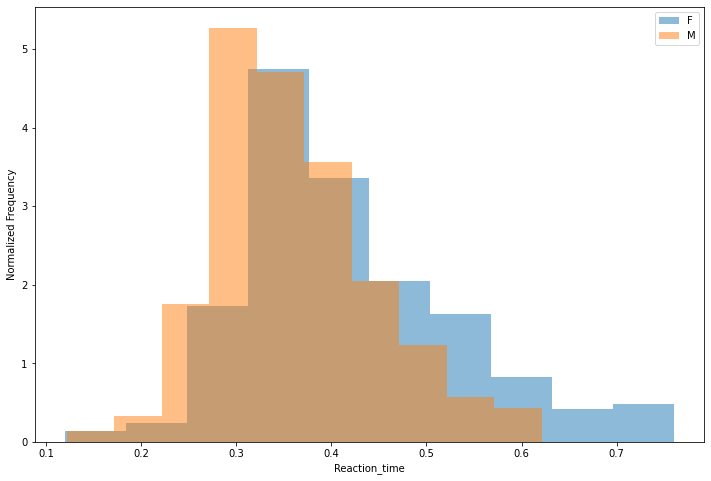

In [15]:
# define a few things upfront
group_names = list(df_G.groups.keys())  # all the gender group names present in the data
quant = 0.25  # quantile to remove outliers 

fig = plt.figure(figsize=[12,8])  # start a new figure with a certain size
ax = fig.gca()                    # get the figure axes

_ = remove_outliers(df_G.get_group(group_names[0])[VALUE_COLUMN], low=quant).plot.hist(ax=ax, figsize=(12,8), legend=True, alpha=0.5, density=SCALED)
for g in group_names[1:]:  # create a subplot for all remaining groups
    try:
        _ = remove_outliers(df_G.get_group(g)[VALUE_COLUMN], low=quant).plot.hist(ax=ax, figsize=(12,8), legend=True, alpha=0.5, density=SCALED)
    except: # sometimes the group keys have NaN values: Not good!
        next
_ = ax.legend(group_names)
_ = ax.set_xlabel(X_TITLE)
_ = ax.set_ylabel('Frequency')
if SCALED: ax.set_ylabel('Normalized Frequency')

Let's do something a bit more exciting!

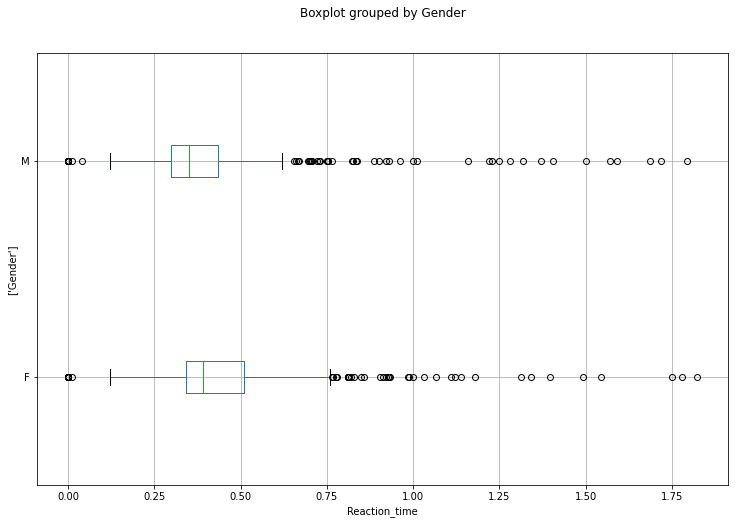

In [16]:
fig = plt.figure(figsize=[12,8])  # start a new figure with a certain size
ax = fig.gca()                    # get the figure axes

_ = df.boxplot(ax=ax, by=GROUPBY, column=VALUE_COLUMN, vert=False)
_ = ax.set_xlabel(X_TITLE)
_ = ax.set_ylabel(Y_TITLE)
_ = ax.set_title('')

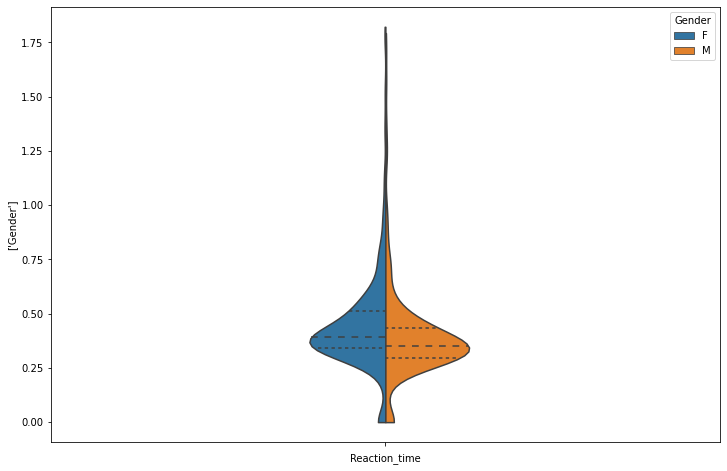

In [17]:
fig = plt.figure(figsize=[12,8])  # start a new figure with a certain size
ax = fig.gca()                    # get the figure axes

dfc = df
# dfc = df.loc[df.Reaction_time <= 1.5]

if len(GROUPBY) == 2:
    _ = sns.violinplot(data=dfc, x=GROUPBY[0], y=VALUE_COLUMN, hue=GROUPBY[1], split=True, inner="quartile", bw=0.25, cut=0)
else:
    dfc['dummy'] = 'A'
    _ = sns.violinplot(data=dfc, x='dummy', y=VALUE_COLUMN, hue=GROUPBY[0], width=0.25, split=True, inner="quartile", bw=0.25, cut=0)
    _ = ax.set_xlabel(X_TITLE)
    _ = ax.set_xticklabels('')
_ = ax.set_ylabel(Y_TITLE)
_ = ax.set_title('')

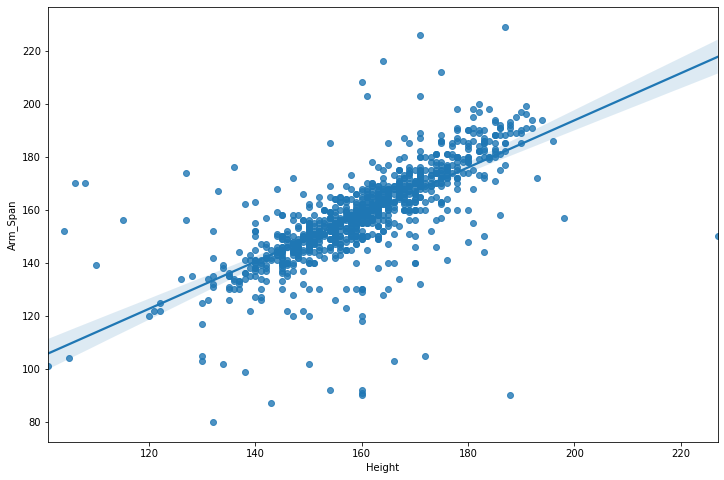

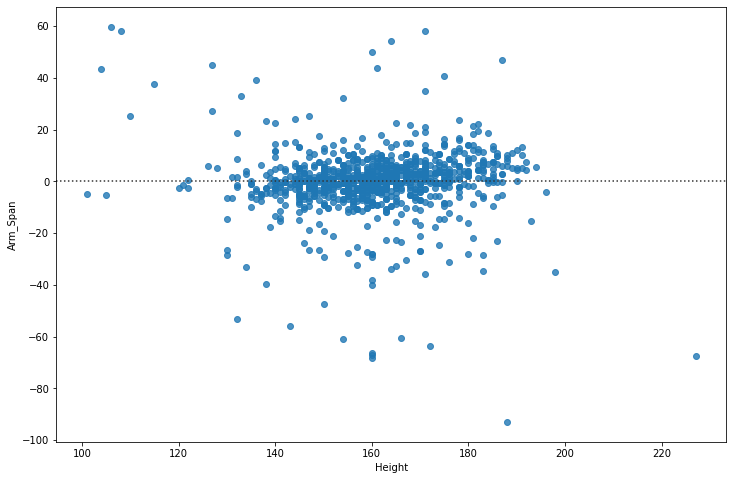

In [25]:
fig = plt.figure(figsize=[12,8])  # start a new figure with a certain size
ax = fig.gca()                    # get the figure axes

_ = sns.regplot(x=df['Height'],y=df['Arm_Span'])

fig = plt.figure(figsize=[12,8])  # start a new figure with a certain size
ax = fig.gca()                    # get the figure axes
_ = sns.residplot(x=df['Height'],y=df['Arm_Span'])

### Same but using a feature rich stats library

In [19]:
X = sm.add_constant(df['Height'])  # make sure the algorithm has enough degrees of freedom
Y = df['Arm_Span']                 # use Arm_Span; Hypothesis: Arm_Span ~= Height
model = sm.OLS(Y, X).fit()         # Perform the fit
print(model.summary())             # show fitting summary

                            OLS Regression Results                            
Dep. Variable:               Arm_Span   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     1031.
Date:                Fri, 02 Oct 2020   Prob (F-statistic):          5.79e-156
Time:                        12:24:19   Log-Likelihood:                -3935.0
No. Observations:                1000   AIC:                             7874.
Df Residuals:                     998   BIC:                             7884.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.2104      4.444      3.648      0.0

### R-squared is 0.508, a reasonable fit, but the data has quite a few outliers

### Cleanup outliers:

In [20]:
out = model.outlier_test()     # check for outliers

select = abs(out['student_resid']) <= 2.  

yfit_df = pd.DataFrame(model.fittedvalues)  # the fitted values (on the line)

Xdf = pd.DataFrame(X.values[:,1])
Ydf = pd.DataFrame(Y)
Xclean = Xdf.loc[(select).values].values # remove all X coords with a residual > 2
Yclean = Ydf.loc[(select).values].values # remove all Y coords with a residual > 2
yfit_clean = yfit_df.loc[(select).values].values

print("{0} outliers identified:".format(len(df['Height']) - len(Xclean)))

# perform the fit without outliers
Xfit = sm.add_constant(Xclean)
cfit = sm.OLS(Yclean, Xfit).fit()
print("Fit results without outliers:")
print(cfit.summary())

56 outliers identified:
Fit results without outliers:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     3565.
Date:                Fri, 02 Oct 2020   Prob (F-statistic):          1.78e-322
Time:                        12:24:19   Log-Likelihood:                -3156.6
No. Observations:                 944   AIC:                             6317.
Df Residuals:                     942   BIC:                             6327.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

### R-squared is now 0.791: quite an improvement!

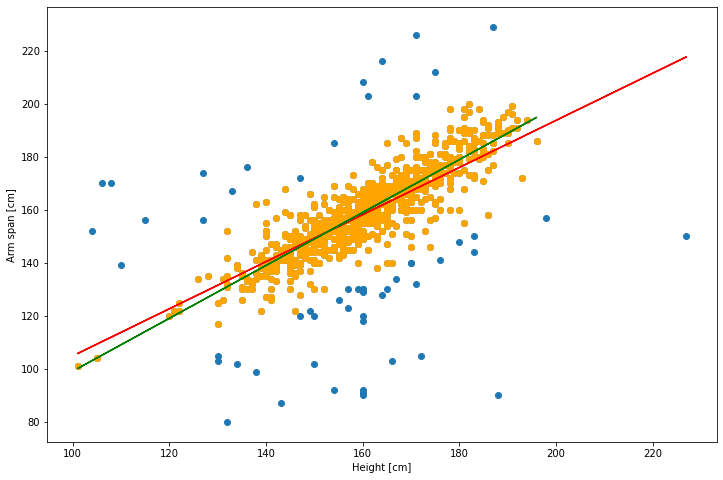

In [21]:
fig = plt.figure(figsize=[12,8])  # start a new figure with a certain size
ax = fig.gca()                    # get the figure axes

_ = plt.scatter(df['Height'], Y)
_ = plt.plot(df['Height'], model.fittedvalues, color="red")     # fit line with outliers
_ = plt.scatter(Xclean, Yclean, color="orange")                 # points selected
_ = plt.plot(Xclean, cfit.fittedvalues, color="green")          # fit line without outliers
ax.set_xlabel('Height [cm]')
ax.set_ylabel('Arm span [cm]')
plt.show()

In [22]:
print(outlier_cutoff(df_f))

{'iqr': 0.16999999999999998, 'lower bound': 0.08500000000000002, 'upper bound': 0.765}


In [23]:
np.sqrt(0.)

0.0